# Directionality charts

Here I attempt to make polar bar charts/histograms for different gpx routes, to display how much they go "in the right direction".


In [242]:
import gpxpy
import matplotlib.pyplot as plt
import numpy
import os


Let's make constants for the routes we want to work with


In [243]:
BHM_TO_STR = "../data/bike/BHM_TO_STR.gpx"
BIC_TO_BED = "../data/bike/BIC_TO_BED.gpx"
BED_TO_SAN = "../data/bike/BED_TO_SAN.gpx"
BIKE_ROUTES = [BHM_TO_STR, BIC_TO_BED, BED_TO_SAN]

MAIN_ROUTE = "../data/cycle.travel/BHM_TO_CAM.gpx"

BIRMINGHAM_COORDS = (-1.9018053, 52.4765926)
CAMBRIDGE_COORDS = (0.1297757, 52.2149504)


Next, functions to load data and display it easily


In [244]:
def get_xy_from_gpx(gpx_filename: str):
    gpx_file = open(gpx_filename, 'r')
    gpx = gpxpy.parse(gpx_file)
    x = []
    y = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                x.append(point.longitude)
                y.append(point.latitude)
    return x, y


Now let's show the bike route vs proposed bike route.


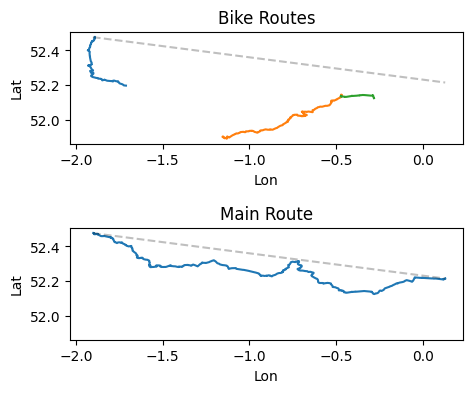

In [245]:

done_coords_1 = get_xy_from_gpx(BHM_TO_STR)
done_coords_2 = get_xy_from_gpx(BIC_TO_BED)
done_coords_3 = get_xy_from_gpx(BED_TO_SAN)

proposed_coords = get_xy_from_gpx(MAIN_ROUTE)

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1)

ax1.plot(done_coords_1[0], done_coords_1[1])
ax1.plot(done_coords_2[0], done_coords_2[1])
ax1.plot(done_coords_3[0], done_coords_3[1])
ax2.plot(proposed_coords[0], proposed_coords[1])

for ax in ax1, ax2:
    ax.set_ylabel('Lat')
    ax.set_xlabel('Lon')
    ax.plot([BIRMINGHAM_COORDS[0], CAMBRIDGE_COORDS[0]],
            [BIRMINGHAM_COORDS[1], CAMBRIDGE_COORDS[1]],
            'k--', alpha=0.25)
    ax.set_aspect('equal')
ax1.set_title('Bike Routes')
ax2.set_title('Main Route')

plt.subplots_adjust(hspace=0.75)
plt.show()


Next, let's calculate the directionality of each route


In [246]:
def coordinates_to_vectors(longs: numpy.ndarray[float], lats: numpy.ndarray[float]):
    """Returns the vectors between points in two lists of coordinates.

    Args:
        longs (numpy.ndarray[float]): The longitudes of the points.
        lats (numpy.ndarray[float]): The latitudes of the points.

    Returns:
        numpy.ndarray[float]: The vectors between the points. Array length is one less than the length of the input lists.
    """
    vectors = []
    for i in range(len(longs) - 1):
        vector = numpy.array([longs[i + 1] - longs[i], lats[i + 1] - lats[i]])
        vectors.append(vector)
    return numpy.array(vectors)


def vectors_to_histogram(vectors: numpy.ndarray[float]):
    """Returns the histogram of the vectors.

    Args:
        vectors (numpy.ndarray[float]): The vectors to be histogrammed.

    Returns:
        numpy.ndarray[float]: The centers of the bins.
        numpy.ndarray[float]: The values of the bins.
        float: The width of the bins.
    """
    bins = numpy.linspace(0, 2 * numpy.pi, 36)
    bin_width = bins[1] - bins[0]
    bin_centers = bins[:-1] + bin_width / 2
    bins = numpy.zeros(len(bin_centers))
    for vector in vectors:
        angle = numpy.arctan2(vector[1], vector[0])
        if angle < 0:
            angle += 2 * numpy.pi
        bin_index = int(angle / bin_width)
        bins[bin_index] += numpy.linalg.norm(vector)
    return bin_centers, bins, bin_width


done_1_vectors = coordinates_to_vectors(*done_coords_1)
done_2_vectors = coordinates_to_vectors(*done_coords_2)
done_3_vectors = coordinates_to_vectors(*done_coords_3)
done_vectors = numpy.concatenate(
    [
        done_1_vectors,
        done_2_vectors,
        done_3_vectors
    ])
proposed_vectors = coordinates_to_vectors(*proposed_coords)
CAMBRIDGE_VECTOR = numpy.array(
    CAMBRIDGE_COORDS) - numpy.array(BIRMINGHAM_COORDS)


Let's compare the bike route and the proposed route


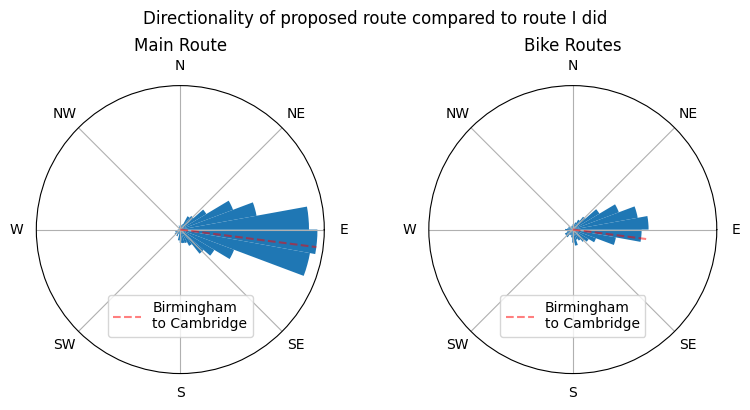

In [247]:

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121, projection='polar')
ax2 = fig.add_subplot(122, projection='polar', sharex=ax1, sharey=ax1)

for ax, vectors in zip([ax1, ax2],
                       [proposed_vectors, done_vectors]):
    bin_centers, bins, bin_width = vectors_to_histogram(vectors)
    ax.bar(bin_centers, bins, width=bin_width)
    CAMBRIDGE_ANGLE = numpy.arctan2(CAMBRIDGE_VECTOR[1], CAMBRIDGE_VECTOR[0])
    ax.vlines(CAMBRIDGE_ANGLE, 0, 1 * max(bins),
              color='r', linestyle='--', alpha=0.5, label='Birmingham\nto Cambridge')
    ax.set_xticks(numpy.linspace(0, 2 * numpy.pi, 8, endpoint=False))
    ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])
    ax.set_yticks([])
    ax.legend(bbox_to_anchor=(0.5, 0.2), loc="center")

ax1.set_title('Main Route')
ax2.set_title('Bike Routes')
plt.suptitle('Directionality of proposed route compared to route I did')
plt.tight_layout()
plt.show()


Let's have a look at the individual bike routes, one by one


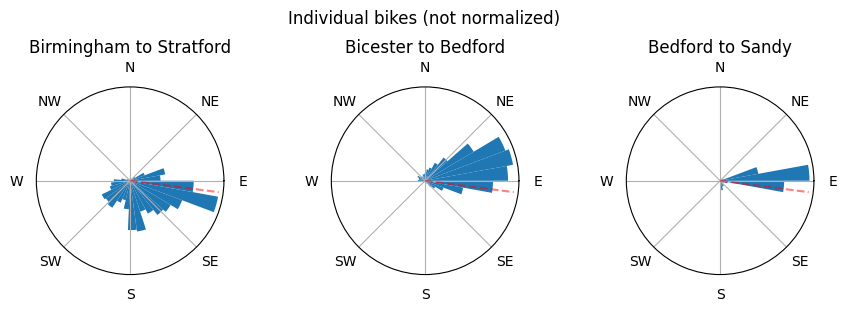

In [248]:
fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_subplot(131, projection='polar')
ax2 = fig.add_subplot(132, projection='polar')
ax3 = fig.add_subplot(133, projection='polar')

for ax, vectors in zip([ax1, ax2, ax3],
                       [done_1_vectors, done_2_vectors, done_3_vectors]):
    bin_centers, bins, bin_width = vectors_to_histogram(vectors)
    ax.bar(bin_centers, bins, width=bin_width)
    CAMBRIDGE_ANGLE = numpy.arctan2(CAMBRIDGE_VECTOR[1], CAMBRIDGE_VECTOR[0])
    ax.vlines(CAMBRIDGE_ANGLE, 0, 1 * max(bins),
              color='r', linestyle='--', alpha=0.5)
    ax.set_xticks(numpy.linspace(0, 2 * numpy.pi, 8, endpoint=False))
    ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])
    ax.set_yticks([])

ax1.set_title('Birmingham to Stratford')
ax2.set_title('Bicester to Bedford')
ax3.set_title('Bedford to Sandy')
plt.suptitle('Individual bikes (not normalized)')
plt.tight_layout()
plt.show()


Now let's make something artistic - just the bars from the histogram.


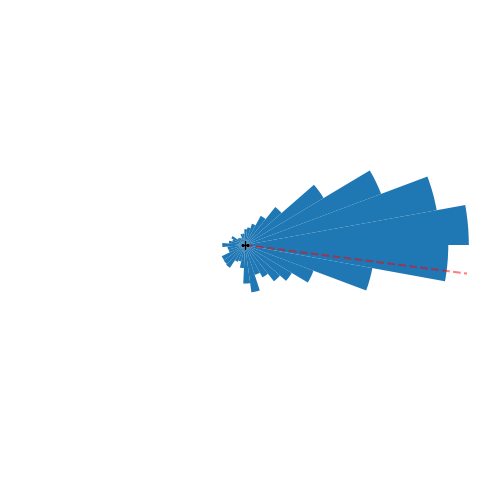

In [269]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='polar')

bin_centers, bins, bin_width = vectors_to_histogram(done_vectors)
ax.bar(bin_centers, bins, width=bin_width)
CAMBRIDGE_ANGLE = numpy.arctan2(CAMBRIDGE_VECTOR[1], CAMBRIDGE_VECTOR[0])
ax.vlines(CAMBRIDGE_ANGLE, 0, 1 * max(bins),
          color='r', linestyle='--', alpha=0.5)
ax.plot(0, 0, '+', color='k')
plt.axis('off')
ax.patch.set_visible(False)
plt.tight_layout()
SVG_FILENAME = 'directionality.svg'
plt.savefig(SVG_FILENAME, transparent=True,
            bbox_inches='tight', pad_inches=0, dpi=300, format='svg', facecolor='none')
plt.show()


Now, let's crop the size of that SVG by deleting the background patch:

```svg
<g id="patch_1">
   <path d="M 0 338.4
L 338.4 338.4
L 338.4 0
L 0 0
L 0 338.4
z
" style="fill: none"/>
  </g>
```

and using Inkscape CLI to crop it:

```bash
inkscape -D <file_in.svg> -o <cropped_file.svg>
```


In [270]:
# open SVG file, find and delete <g id="patch_1">...</g>
with open(SVG_FILENAME, 'r') as f:
    svg = f.read()
patch_start = svg.find('<g id="patch_1">')
if patch_start != -1:
    patch_end = svg.find('</g>', patch_start) + len('</g>')
    svg = svg[:patch_start] + svg[patch_end:]
    with open(SVG_FILENAME, 'w') as f:
        f.write(svg)

# use inkscape command line to crop to content
OUT_FILE = "../images/directionality.svg"
command = 'inkscape --export-filename=../images/directionality.svg --export-area-drawing directionality.svg'
stream = os.popen('inkscape --export-filename=../images/directionality.svg --export-area-drawing directionality.svg'
                  )
output = stream.read()
print(output if output else 'No output!')

print("This doesn't work?")
print("Try running the following command in the terminal:")
print(command)


No output!
This doesn't work?
Try running the following command in the terminal:
inkscape --export-filename=../images/directionality.svg --export-area-drawing directionality.svg


<g id="patch_1">
